# Partie Preprocessing (sur Google Colab):
* Chargement des datasets 
* Feature engineering
* Suppression des colonnes avec taux de remplissage < 80%
* Imputation des données manquantes avec SimpleImputer, avec comme stratégie la médiane.
* sauvegarde du dataframe preprocessed.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import des bibiliothèques nécessaires:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Code pour lecture des fichiers csv dans google Colab:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# ID links
id_app= '1y81rw4gZCUf_hVIMYKPenNxiH7a8Nit0' # application_train.csv
id_b= '1_rjLHVgUxdqpGMO0mJAdaOSmk4xZMaKw' # bureau.csv
id_bb= '1UUMkrdBPrIln-PoNA5UdOn4gG2Ma2kMH' # bureau_balance.csv
id_ccb= '1Y_Aq9oGJcTdKB7A0B1sxf1ckvohfdH3Z' # credit_card_balance.csv
id_pcb= '1K3j_UsVZvO0L0N8bbbvEnnBrcavYYwwk' # POS_CASH_balance.csv
id_pa= '1sDTtfSr7B9goM6eqIglCMoD45ePoz8A2' # previous_application.csv
id_ip= '1bb3zmkF3l26a1Y5D6Lh_ZIDFA0FE6E7-' # installments_payments.csv


In [ ]:
# Download of application_train.csv
downloaded = drive.CreateFile({'id':id_app}) 
downloaded.GetContentFile('application_train.csv')  
df_app = pd.read_csv('application_train.csv')

In [ ]:
# Download of bureau.csv
downloaded = drive.CreateFile({'id':id_b}) 
downloaded.GetContentFile('bureau.csv')  
df_b = pd.read_csv('bureau.csv')

In [ ]:
# Dowload of bureau_balance.csv
downloaded = drive.CreateFile({'id':id_bb}) 
downloaded.GetContentFile('bureau_balance.csv')  
df_bb = pd.read_csv('bureau_balance.csv')

In [ ]:
# Download of credit_card_balance.csv
downloaded = drive.CreateFile({'id':id_ccb}) 
downloaded.GetContentFile('credit_card_balance.csv')  
df_ccb = pd.read_csv('credit_card_balance.csv')

In [ ]:
# Dowload of POS_CASH_balance.csv
downloaded = drive.CreateFile({'id':id_pcb}) 
downloaded.GetContentFile('POS_CASH_balance.csv')  
df_pcb = pd.read_csv('POS_CASH_balance.csv')

In [ ]:
# Download of previous_application.csv
downloaded = drive.CreateFile({'id':id_pa}) 
downloaded.GetContentFile('previous_application.csv')  
df_pa = pd.read_csv('previous_application.csv')

In [ ]:
# Download of installments_payments.csv
downloaded = drive.CreateFile({'id':id_ip}) 
downloaded.GetContentFile('installments_payments.csv')  
df_ip = pd.read_csv('installments_payments.csv')

#### Fonction pour encodage des variables catégorielles:

In [ ]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object'] # list des variables catégorielles
    df = pd.get_dummies(df, columns= categorical_columns)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df

#### Function of preprocessing de "application_train.csv" 

In [ ]:
# Preprocess application_train.csv
def application_train(df):
    # df length
    print("df samples: {}".format(len(df)))
    
    # Optional: Remove 4 applications with XNA CODE_GENDER
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df = one_hot_encoder(df)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df

#### Function of preprocessing bureau.csv & bureau_balance.csv

In [ ]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(df_b, df_bb):
    bureau = one_hot_encoder(df_b)
    bb = one_hot_encoder(df_bb)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    #for col in bb_cat:
       #"bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

### Function of preprocessing previous_applications.csv

In [ ]:
# Preprocess previous_applications.csv
def previous_applications(df_ap):
    prev = one_hot_encoder(df_ap)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

### Function of preprocessing POS_CASH_balance.csv

In [ ]:
# Preprocess POS_CASH_balance.csv
def pos_cash(df_pcb):
    pos = one_hot_encoder(df_pcb)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

### Function of preprocessing installments_payments.csv

In [ ]:
# Preprocess installments_payments.csv
def installments_payments(df_ip):
    ins = one_hot_encoder(df_ip)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

### Function of preprocessing credit_card_balance.csv

In [ ]:
# Preprocess credit_card_balance.csv
def credit_card_balance(df_ccb):
    cc= one_hot_encoder(df_ccb)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

### Merge des Dataframes:

In [ ]:
df = application_train(df_app)
bureau = bureau_and_balance(df_b,df_bb)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
gc.collect()

prev = previous_applications(df_pa)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
gc.collect()

pos = pos_cash(df_pcb)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()

ins = installments_payments(df_ip)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
gc.collect()

cc = credit_card_balance(df_ccb)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc
gc.collect()

df samples: 307511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Bureau df shape: (305811, 81)
Previous applications df shape: (338857, 90)
Pos-cash balance df shape: (337252, 8)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 136)


0

In [ ]:
# Visualtisation du dataframe après le merge:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Infos sur le dataframe après le merge:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Columns: 588 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(412), int64(43), uint8(133)
memory usage: 1.1 GB


In [ ]:
# Visualisation de la distribution des classes du feature TARGET:
df.TARGET.value_counts()

0    282682
1     24825
Name: TARGET, dtype: int64

Class 0: 282682
Class 1: 24825
Proportion: 11.39 : 1


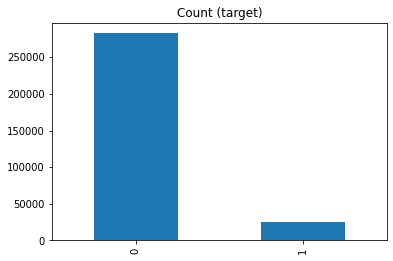

In [ ]:
target_count = df.TARGET.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

* On remarque que les classes sont très déséquilibrées.
* D'où l'équilibrage avec SMOTE (Synthetic Minority Oversampling Technique) dans la prochaine partie.

In [ ]:
# Calcul du taux de remplissage par colonne:
col= df.columns.tolist()
df_rate= pd.DataFrame(columns=['col','Taux de remplissage'])
for column in col:
    col_obj= df[column]
    null_rate=round(1-(col_obj.isnull().sum()/float(len(df))),2)
    df_rate= df_rate.append({'col':column, 'Taux de remplissage':null_rate },ignore_index=True)

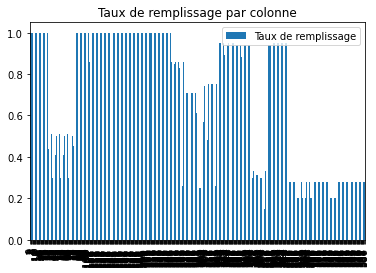

In [ ]:
# Visualisaton des taux de remplissage:
df_rate.plot(kind='bar', title='Taux de remplissage par colonne')

In [ ]:
# On écarte les colonnes avec un taux de remplissage < 80%:
lst_col= df_rate[df_rate['Taux de remplissage']>= 0.8].col.to_list()
df= df[lst_col]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Columns: 313 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: float64(137), int64(43), uint8(133)
memory usage: 463.6 MB


In [ ]:
# vérification s'il existe des données manquantes pour la variable TARGET => Aucun NaN
df.TARGET.isna().value_counts()

False    307507
Name: TARGET, dtype: int64

### Imputation des données manquantes:

In [ ]:
 # On écarte les lignes avec les valeurs infinies (étape nécessaire avant simpleImputer )
 df= df[~df.isin([np.inf, -np.inf]).any(1)]

In [ ]:
# Fill in the NaN values with simpleImputer
from sklearn.impute import SimpleImputer
lst_col= df.columns.to_list()
# Fill in with mean value of each column
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
df= imp_mean.fit_transform(df)
df= pd.DataFrame(df,columns= lst_col )

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307488 entries, 0 to 307487
Columns: 313 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: float64(313)
memory usage: 734.3 MB


In [ ]:
# On place le feature (SK_ID_CURR) qui représente l'identifiant unique du client comme index du dataframe:
df.set_index('SK_ID_CURR')

In [ ]:
# Formatage des noms de colonnes:
df.columns = df.columns.str.lower()
df.columns = df.columns.map(lambda x : x.replace("-", "_").replace(" ", "_"))
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
# on sauvegarde le df:
df.to_csv('df.csv',index=False)

In [ ]:
#On charge le dataframe:
df= pd.read_csv('df.csv')